In [0]:
# Import Libraries
import torch
from torch import *
from torch.distributions import Categorical
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [0]:
class envChannel:
  def __init__(self, n_users, n_channels, memory, k=1, p =0.75):
    self.memory = memory
    self.n_users = n_users
    self.p = p
    self.n_channels = n_channels
    self.k = k # Hard-coded for ease of use, but potentially should allow for "N choose k" options
    self.action_space = np.arange(self.n_channels+1) # what possible actions (i.e. channels) can an user pick
    self.users_action = np.zeros([self.n_users]) # what channel is picked
    self.obs = np.zeros((memory, 
                         self.n_users)) # what state channels are in
    temp = np.random.choice(2, self.n_channels)
    self.state = temp.reshape(1, self.n_channels)
    #print(type(self.state))
    #print(temp.shape, self.state.shape)

  def reset(self):
    return self.state # assumption is that the probability is 0.5 of channel state being switched
    #return state.reshape(1, self.n_channels)
  
  def sample(self):
    return np.random.choice(self.action_space, size=self.n_users) # randomly choose one of the channels

  def step(self, actions, channel_states):
    # Initialize the reward, discountfactor and the observation vectors
    reward = []
    discountfactor = np.zeros([self.n_channels])
    
    obs_t = channel_states[0]
    #print(obs_t)
    ## New channel states

    # Compute the discount factor
    for indx in range(len(actions)):
      action = actions[indx]
      discountfactor[action]+=1 # how many users in a channel

    
      # For non-observed channels indicate the observations as 0, otherwise do the switching for the others

    # Find the reward per user at time t
    for user in range(n_users):
      action = actions[user]
      if discountfactor[action]!=0: # If at least one user selected the channel
        if channel_states[0][action] == 1: # If its a good state channel
          if discountfactor[action]>1:
            reward.append(1/(discountfactor[action]))
          else:
            reward.append(1) # good channel with no collision
        else: # If the channel is in a bad state
          reward.append(-1)
    #print(reward)
    state = np.zeros([self.n_channels]) # decide on the next input to AC
    
    #print('nchan', self.n_channels)
    for channel in range(self.n_channels): # Find the states
      #print('t')
      if discountfactor[channel] == 1: # If only one user selected the channel, the state is just the observation
        #print('p')
        state[channel] = obs_t[channel]
      elif discountfactor[channel] > 1: # Otherwise the state is for multiple users
        if channel_states[0][channel] == 1: # if channel was in good state
          state[channel]=1/(discountfactor[channel]) # Then factor in the discount factor
        elif channel_states[0][channel] == -1: 
          state[channel] = -1 # Just make it 1 for a bad state channel'''
        elif channel_states[0][channel] == 0:
          state[channel] = 0
      else: # if no one accessed the channel
        state[channel] = 0
    #print(state)
    #}print('s', state, obs_t)
    for indx in range(n_channels): # Update new observation with switching probability p (only if actions allow you to view it)
      
        #print('yo')
        #print(self.p)
      if np.random.rand() < self.p: # swtiching probability
        obs_t[indx] = ((channel_states[0][indx]+1)%2)
      else:
        obs_t[indx] = channel_states[0][indx]

    #self.state = obs_t.reshape(1, n_channels)
    #print('r', reward)
    return state, obs_t, reward # returns observations (new) and the rewards obtained


    

In [0]:
# Class which creates the Actor Critic Model
# Takes inputs of action space as n_inputs, n_outputs are the number of channels
# hidden indicates the number of neurons in the hidden layer
class Actor(nn.Module):
  def __init__(self, n_inputs, n_outputs, hidden):
    super(Actor, self).__init__()
    #self.actor = nn.Sequential(
    self.l1 = nn.Linear(n_inputs, hidden)
    self.r = nn.ReLU()
    self.l2 = nn.Linear(hidden, n_outputs)
    self.smax = nn.Softmax(dim=1)
    #)

  def forward(self, x):
    x = self.l1(x)
    x = self.r(x)
    x = self.l2(x)
    scores = self.smax(x)
    return Categorical(scores)

class Critic(nn.Module):
  def __init__(self, n_inputs, hidden):
    super(Critic, self).__init__()
    self.critic = nn.Sequential(
        nn.Linear(n_inputs, hidden),
        nn.ReLU(),
        nn.Linear(hidden, 1)
    )

  def forward(self, x):
    value = self.critic(x)
    return value

In [0]:
#AC

# Define the parameters
n_envs = 8 # general default for AC
n_users = 1
n_channels = 8
memory = 1

model_actor = Actor(n_channels, n_channels, 200).to(device)
optimizer_actor = optim.Adam(model_actor.parameters(), lr=10**(-3))

model_critic = Critic(n_channels, 200).to(device)
optimizer_critic = optim.Adam(model_critic.parameters(), lr=5*(10**(-3)))

In [0]:


def runner(p):
  sums = 0

  T = 10000
  sums_random = 0
  r_random = []
  Rewards_total = []
  env = envChannel(n_users, n_channels, memory, p)
  state = env.reset()
  channel_states = torch.from_numpy(state).float().to(device)
  
  modelsA, modelsC = [], []
  optA, optC = [], []
  for indx in range(n_users):
    modelsA.append(Actor(n_channels, n_channels, 200).to(device))
    optA.append(optim.Adam(modelsA[-1].parameters(), lr=10**(-3)))

    modelsC.append(Critic(n_channels, 200).to(device))
    optC.append(optim.Adam(modelsC[-1].parameters(), lr=5*(10**(-3))))

  #nrewards = []
  for t_indx in range(T):
   
  #if T%250000==0:
    actions = []
    delta = []
    values, log_probs = [], []
     # tells which channel is in what state
    
    state_tensor = torch.from_numpy(state).float().to(device)
    for user in range(n_users): # loop over each user to get the current state
      value = modelsC[user](state_tensor) # passed to critic for a single user
      values.append(value)
      dist = modelsA[user](state_tensor) # passed to obtain distribution of the policy
      action = dist.sample() # get the action of the user
      actions.append(action)
      log_prob = dist.log_prob(action)
      log_probs.append(log_prob)

    df = np.zeros([n_channels])
    rand_choice = np.random.choice(n_channels, n_users)
    for indx in range(len(rand_choice)):
      action = rand_choice[indx]
      df[action]+=1 # how many users in a channel
    r_random_small = []
    for user in range(n_users):
      action = rand_choice[user]
      if df[action]!=0: # If at least one user selected the channel
        if channel_states[0][action] == 1: # If its a good state channel
          if df[action]>1:
            r_random_small.append(1/(df[action]))
          else:
            r_random_small.append(1) # good channel with no collision
        else: # If the channel is in a bad state
          r_random_small.append(-1)

    actions = torch.cat(actions)
    #print(channel_states)
    next_state, channel_states, rewards = env.step(actions.cpu().numpy(), channel_states) # get rewards and next states
    channel_states = np.array([channel_states])
    #nrewards = []
    next_state = next_state.tolist()
    #print(type(next_state))
  #for reward in rewards:
    #nrewards.append(torch.tensor(reward, requires_grad=True).unsqueeze(0).to(device))
  #print(rewards)
    nrewards = []
    nrewards.append(torch.from_numpy(np.array(rewards)).float().to(device))
    nrewards = torch.cat(nrewards) 
    log_probs = torch.cat(log_probs)
    values = torch.cat(values)
    closs, aloss = [], []
    #print(state)
    for user in range(n_users):
      next_state_tensor =  torch.from_numpy(np.array(next_state)).float().to(device)
      next_value = modelsC[user](next_state_tensor)
      #print(next_value, value, nrewards[0])

      temp = nrewards[user]+0.9*next_value - values[user]
      temp_var = Variable(temp, requires_grad=True)
      delta.append(temp)

      closs.append(temp_var.pow(2).mean())
      optC[user].zero_grad()
      closs[-1].backward(retain_graph=True)
      optC[user].step()

      aloss.append(-(log_probs * temp_var.detach()).mean())
      optA[user].zero_grad()
      aloss[-1].backward(retain_graph=True)
      optA[user].step()
    #print(nrewards)
    if t_indx%1==0:
      sums+=nrewards.mean()
      Rewards_total.append(sums)
      #nrewards = []
      sums_random+=np.array(r_random_small).mean()
      r_random.append(sums_random)
      sums = 0
      sums_random = 0
  #log_probs = torch.from_numpy(np.array(log_probs))
    delta = torch.cat(delta).detach()
    delta_var = Variable(delta, requires_grad=True)
  #print(delta)
  #values    = torch.from_numpy(np.array(values)).float().to(device)

  #t_state = np.random.choice(2, n_channels)
  #state = t_state.reshape(1, n_channels)
  #for indx in range(len(state)):
  #  if np.random.rand() < p: # swtiching probability
  #    channel_states[indx] = ((channel_states[indx]+1)%2)

 # print(state)

    state = np.array([next_state]) # switch to next state
    #print(state)

    '''critic_loss = delta_var.pow(2).mean()
    optimizer_critic.zero_grad()
    critic_loss.backward()
    optimizer_critic.step()

    actor_loss  = -(log_probs * delta_var.detach()).mean()
    optimizer_actor.zero_grad()
    actor_loss.backward()
    optimizer_actor.step()'''



  total = sum(Rewards_total)/len(Rewards_total)
  rtotal = sum(r_random)/len(r_random)
  return Rewards_total, total, rtotal, modelsA, modelsC

  print("Total", sum(Rewards_total)/len(Rewards_total))




In [0]:
def test_env(modelsA, n_users, p=0.75, T_iters=1000):
  env = envChannel(n_users, n_channels, memory, p)
  state = env.reset()

  sums = 0
  sums_random = 0
  Rewards_total = [];r_random = []
  channel_states = torch.from_numpy(state).float().to(device)
  t_indx=0
  
  while t_indx < T_iters:
    #print(t_indx, T_iters)
    state_tensor = torch.from_numpy(state).float().to(device)
    actions = []
    for user in range(n_users): # loop over each user to get the current state
      #value = modelsC[user](state_tensor) # passed to critic for a single user
      #values.append(value)
      dist = modelsA[user](state_tensor) # passed to obtain distribution of the policy
      action = dist.sample() # get the action of the user
      actions.append(action)
    
    actions = torch.cat(actions)
    
    next_state, channel_states, rewards = env.step(actions.cpu().numpy(), channel_states)
    channel_states = np.array([channel_states])
    nrewards = []
    next_state = next_state.tolist()
    nrewards.append(torch.from_numpy(np.array(rewards)).float().to(device))
    nrewards = torch.cat(nrewards)

    df = np.zeros([n_channels])
    rand_choice = np.random.choice(n_channels, n_users)
    for indx in range(len(rand_choice)):
      action = rand_choice[indx]
      df[action]+=1 # how many users in a channel
    r_random_small = []
    for user in range(n_users):
      action = rand_choice[user]
      if df[action]!=0: # If at least one user selected the channel
        if channel_states[0][action] == 1: # If its a good state channel
          if df[action]>1:
            r_random_small.append(1/(df[action]))
          else:
            r_random_small.append(1) # good channel with no collision
        else: # If the channel is in a bad state
          r_random_small.append(-1)

    if t_indx%1==0:
      sums+=nrewards.mean()
      Rewards_total.append(sums)
      sums_random+=np.array(r_random_small).mean()
      r_random.append(sums_random)
      sums = 0
      sums_random = 0
    t_indx+=1
    state = np.array([next_state]) # update to next state

  total = sum(Rewards_total)/len(Rewards_total)
  rtotal = sum(r_random)/len(r_random)
  return Rewards_total, total, rtotal

    

In [0]:
# Run for the various probabilities

r75, t75, rand75, mA75, _ = runner(0.75)
r80, t80, rand80, mA80, _ = runner(0.80)
r85, t85, rand85, mA85, _ = runner(0.85)
r90, t90, rand90, mA90, _ = runner(0.90)

In [0]:
r75, tt75, trand75 = test_env(mA75, n_users, p=0.75, T_iters=10000)
r80, tt80, trand80 = test_env(mA80, n_users, p=0.80, T_iters=10000)
r85, tt85, trand85 = test_env(mA85, n_users, p=0.85, T_iters=10000)
r90, tt90, trand90 = test_env(mA90, n_users, p=0.90, T_iters=10000)

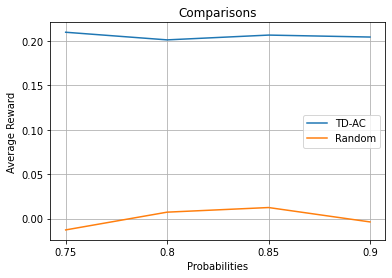

In [142]:
#print(t75, t80, t85, t90)
prob = [0.75, 0.8, 0.85, 0.9]
plt.plot(prob, [tt75, tt80, tt85, tt90], label='TD-AC')
plt.plot(prob, [trand75, trand80, trand85, trand90], label='Random')
plt.xticks(prob, prob)
plt.legend()
plt.grid()
plt.ylabel('Average Reward')
plt.xlabel('Probabilities')

plt.title('Comparisons')
plt.savefig('first.png', bbox_inches='tight')
plt.show()

In [143]:
# Time difference for more users

import time

start = time.time()
n_users = 1
n_channels = 8
r75, t75, rand75, _, _ = runner(0.75)
end = time.time()
print(end - start)

start = time.time()
n_users = 5
n_channels = 8
r75, t75, rand75, _, _ = runner(0.75)
end = time.time()
print(end - start)


ValueError: ignored

In [0]:
# Implementing A2C

envs = []
p = 0.75
n_threads = 2
n_users = 1
n_channels = 8
for _ in range(n_threads):
  envs.append(envChannel(n_users, n_channels, memory, p))

In [0]:
class ActorCritic(nn.Module):
  def __init__(self, n_inputs, n_outputs, hidden):
    super(ActorCritic, self).__init__()
    self.actor = nn.Sequential(
      nn.Linear(n_inputs, hidden),
      nn.ReLU(),
      nn.Linear(hidden, n_outputs),
      nn.Softmax(dim=1)
    )
    self.critic = nn.Sequential(
        nn.Linear(n_inputs, hidden),
        nn.ReLU(),
        nn.Linear(hidden, 1)
    )

  def forward(self, x):
    value, scores = self.critic(x), self.actor(x)
    return value, Categorical(scores)

In [0]:
model_actor = Actor(n_channels, n_channels, 200).to(device)
optimizer_actor = optim.Adam(model_actor.parameters(), lr=10**(-4))

model_critic = Critic(n_channels, 200).to(device)
optimizer_critic = optim.Adam(model_critic.parameters(), lr=5*(10**(-4)))

In [0]:
def runner2(p):
  n_threads = 8
  env_states = []
  for _ in range(n_threads): # create the environment and store the intial states
    env_temp = envChannel(1, 8, memory, p)
    envs.append(env_temp)
    state_temp = env_temp.reset()
    #print(state_temp)
    env_states.append(state_temp)
  sums = 0
  env_CS = []
  T = 10000
  sums_random = 0
  r_random = []
  Rewards_total = []
  for env_index in range(n_threads):  
      env_CS.append(torch.from_numpy(env_states[env_index]).float().to(device))
  for t_indx in range(T):
    actions = []
    delta = []
    values, log_probs = [], []
    NS, CS, R = [], [], []
    for env_index in range(n_threads):
      #print(envs[env_index])
      state_tensor = torch.from_numpy(env_states[env_index]).float().to(device) # convert to a tensor
      #print(state_tensor)
      #env = envs[env_index]
      value = model_critic(state_tensor) # passed to critic for a single user
      values.append(value)
      dist = model_actor(state_tensor) # passed to obtain distribution of the policy
      action = dist.sample() # get the action of the user
      actions.append(action)
      log_prob = dist.log_prob(action)
      log_probs.append(log_prob)
    #actions = torch.cat(actions)
    for env_index in range(n_threads):  
      #channel_states = torch.from_numpy(env_states[env_index]).float().to(device)
      #print('c', env_states[env_index])
      #print(actions[env_index])
      next_state, cs1, rewards = envs[env_index].step(torch.tensor(actions[env_index]).cpu().numpy(), env_CS[env_index])
      #print('c2', env_CS[env_index])
      #print('w', next_state, cs1, rewards)
      NS.append(next_state)
      CS.append(cs1.cpu().numpy())
      R.append(rewards)
    #print(CS)
    NS = np.stack(NS);CS = np.stack(CS)
    #print(CS)
    for env_index in range(n_threads): 
      env_CS.append(np.array([CS[env_index]]))
    R = np.stack(R)
    nrewards = []
    NS = NS.tolist()
    
    nrewards.append(torch.from_numpy(R).float().to(device))
    nrewards = torch.cat(nrewards) 

    #print(nrewards, nrewards.mean())
    log_probs = torch.cat(log_probs)
    values = torch.cat(values)
    #print(NS)
    if t_indx%1==0:
      sums+=nrewards.mean()
      Rewards_total.append(sums)
      sums = 0
    next_value = []
    for env_index in range(n_threads): 
      next_state_tensor = torch.from_numpy(np.array(NS[env_index])).float().to(device)
      next_value.append(model_critic(next_state_tensor))
    #print(values.shape)
    #print(values, next_value, nrewards)
    next_value = torch.cat(next_value)
    temp = nrewards+0.99*next_value - values
    temp_var = Variable(temp, requires_grad=True)
    closs = temp_var.pow(2).mean()
    optimizer_critic.zero_grad()
    closs.backward()
    optimizer_critic.step()

    aloss=-(log_probs * temp_var.detach()).mean()
    optimizer_actor.zero_grad()
    aloss.backward()
    optimizer_actor.step()
    for env_index in range(n_threads):
      state = np.array([NS[env_index]])
      #print('m', state[0])
      env_states[env_index] = state
    #print('final', env_states)
  total = sum(Rewards_total)/len(Rewards_total)
  return Rewards_total, total, model_actor




In [278]:
at75, a2c75, mA2_75 = runner2(0.75)
print('75')
at80, a2c80, mA2_80 = runner2(0.8)
at85, a2c85, mA2_85 = runner2(0.85)
at90, a2c90, mA2_90 = runner2(0.9) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


75


In [0]:
r75, a2c75, trand75 = test_env([mA2_75], n_users, p=0.75, T_iters=10000)
r80, a2c80, trand80 = test_env([mA2_80], n_users, p=0.80, T_iters=10000)
r85, a2c85, trand85 = test_env([mA2_85], n_users, p=0.85, T_iters=10000)
r90, a2c90, trand90 = test_env([mA2_90], n_users, p=0.90, T_iters=10000)

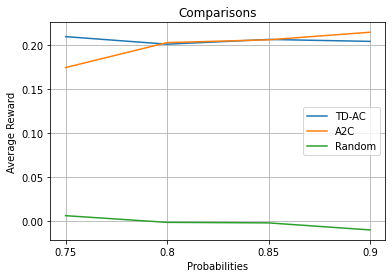

In [280]:
#print(t75, t80, t85, t90)
prob = [0.75, 0.8, 0.85, 0.9]
plt.plot(prob, [tt75, tt80, tt85, tt90], label='TD-AC')
plt.plot(prob, [a2c75, a2c80, a2c85, a2c90], label='A2C')
plt.plot(prob, [trand75, trand80, trand85, trand90], label='Random')
plt.xticks(prob, prob)
plt.legend()
plt.grid()
plt.ylabel('Average Reward')
plt.xlabel('Probabilities')

plt.title('Comparisons')
plt.savefig('first.png', bbox_inches='tight')
plt.show()
